In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy

import sys
sys.path.append('../')
from methods import permutation_test
from models import JitterCI
from plotting_functions import set_size, colorbar_axis
from utils import rotation_matrix

In [4]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = True
dpi=150

In [5]:
def train_model(model, nsamples_space=2**8, epochs=2000):
    # Train model
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(epochs):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=torch.float32)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    loss_history = np.array(loss_history)
    metric_history = np.array(metric_history)
    phases_history = np.array(phases_history)
    G_history = np.array(G_history)
    return loss_history, phases_history, metric_history, G_history

In [6]:
# load trained model
dtype = torch.float32
#model = JacobianCI(ncells=7*15,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0)
models = []
nmodels = 10
epochs = 500
for i in range(nmodels):
    model = JitterCI(ncells=7*30,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0)
    loss_history, phases_history, metric_history, G_history = train_model(model,epochs=epochs)
    # set best phases based on lowest loss
    #best_phases = phases_history[np.argmin(loss_history)+1]
    #model.set_phases(best_phases)
    models.append(model)

100%|██████████| 500/500 [00:08<00:00, 59.20it/s]


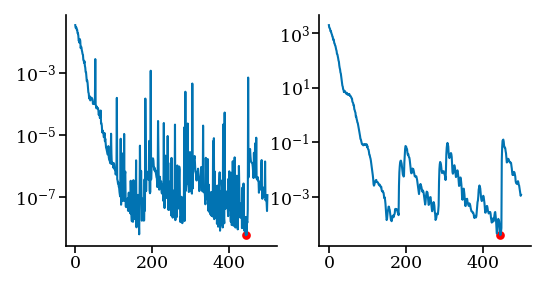

In [7]:
fig, axs = plt.subplots(1,2,figsize=(4,2))
axs[0].semilogy(loss_history)
axs[0].scatter(np.argmin(loss_history),np.min(loss_history), s=10, c='red')
axs[1].semilogy(metric_history)
axs[1].scatter(np.argmin(metric_history),np.min(metric_history), s=10, c='red')

(-0.7333333333333333,
 0.7333333333333333,
 -0.6350852961085885,
 0.6350852961085884)

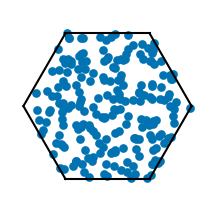

In [8]:
fig,ax = model.unit_cell.plot(color='black')
ax.scatter(*phases_history[-1].T,s=10)
ax.axis('equal')
ax.axis('off')

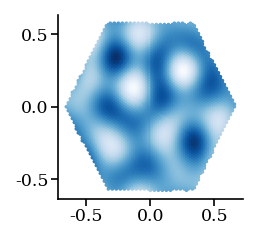

In [9]:
kde, mesh, kernel, expanded_phases = model.phase_kde(bw_method=0.1)
plt.scatter(*mesh.T, c=kde, s=0.5)

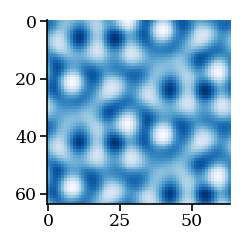

In [10]:
res = 64
bins = np.linspace(-model.unit_cell.radius*3/2, model.unit_cell.radius*3/2, res)
xx, yy = np.meshgrid(bins, bins)
square_mesh = np.stack((xx, yy), axis=-1)  # (res,res,2)
# evaluate kernel
ratemap = kernel(square_mesh.reshape(-1, 2).T).reshape(res, res)
plt.imshow(ratemap)

In [11]:
radii = np.linspace(0, model.unit_cell.radius/2, 21)[1:]
random_grid_scores = np.zeros((nmodels,len(radii)))
optimal_grid_scores = np.zeros((nmodels,len(radii)))
bins=20
random_freqs = np.zeros((nmodels,bins))
optimal_freqs = np.zeros((nmodels,bins))
for i,model in enumerate(tqdm.tqdm(models)):
    for j,radius in enumerate(radii):
        random_grid_scores[i,j] = model.grid_score(phases=model.unit_cell.sample(len(model.phases)),bw_method=radius)
        optimal_grid_scores[i,j] = model.grid_score(bw_method=radius)
    random_freq,_ = np.histogram(random_grid_scores[i],bins=bins)
    optimal_freq,_ = np.histogram(optimal_grid_scores[i],bins=bins)
    random_freqs[i] = random_freq
    optimal_freqs[i] = optimal_freq

100%|██████████| 10/10 [06:36<00:00, 39.62s/it]


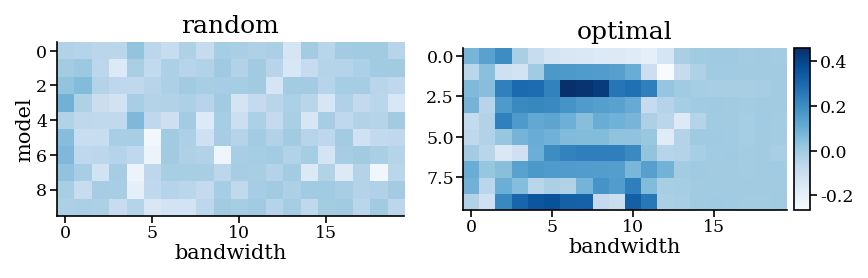

In [12]:
fig,axs = plt.subplots(ncols=2,figsize=(6,3))
vmin, vmax = min(np.min(random_grid_scores),np.min(optimal_grid_scores)), max(np.max(random_grid_scores),np.max(optimal_grid_scores))
im0 = axs[0].imshow(random_grid_scores, vmin=vmin, vmax=vmax)
#axs[0].axis('off')
axs[0].set_xlabel('bandwidth')
axs[0].set_ylabel('model')
axs[0].set_title('random')
#colorbar_axis(fig, axs[0], im0)
im1 = axs[1].imshow(optimal_grid_scores, vmin=vmin, vmax=vmax)
#axs[1].axis('off')
axs[1].set_xlabel('bandwidth')
#axs[1].set_ylabel('model')
axs[1].set_title('optimal')
colorbar_axis(fig, axs[1], im1)
plt.tight_layout()

Text(0, 0.5, 'grid score')

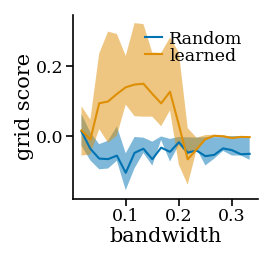

In [38]:
random_grid_scores = np.sort(random_grid_scores,axis=0)
optimal_grid_scores = np.sort(optimal_grid_scores,axis=0)
plt.plot(radii,random_grid_scores.mean(axis=0),label='random')
percentile = 0.2
plt.fill_between(radii,random_grid_scores[int(nmodels*percentile)],
                 random_grid_scores[int(nmodels*(1-percentile))],alpha=0.5)
plt.plot(radii,optimal_grid_scores.mean(axis=0),label='learned')
plt.fill_between(radii,optimal_grid_scores[int(nmodels*percentile)],
                optimal_grid_scores[int(nmodels*(1-percentile))],alpha=0.5)
plt.legend()
plt.xlabel('bandwidth')
plt.ylabel('grid score')

## Do Ripleys Statistics on Phases

In [35]:
from joblib import Parallel, delayed

nperms = 200
def calculate_values(radius):
    rv_models = [model.ripleys(radius) for model in models]
    rv_random = [model.ripleys(radius, phases=model.unit_cell.sample(len(model.phases))) for model in models]
    stat, p, H0 = permutation_test(rv_models, rv_random, statistic=None, nperms=nperms, alternative='two-sided')
    return stat, p, H0

# Using joblib to parallelize the computation
ball_radii = np.linspace(0, model.unit_cell.radius, 21)[1:]
results = Parallel(n_jobs=-1)(delayed(calculate_values)(radius) for radius in ball_radii)
# Unzipping the results into separate lists
stats, ps, H0s = zip(*results)
# convert to numpy arrays
stats, ps, H0s = np.array(stats), np.array(ps), np.array(H0s)


100%|██████████| 200/200 [00:00<00:00, 72616.07it/s]


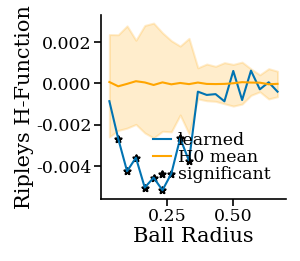

In [39]:
plt.plot(ball_radii,stats,label='learned')
# u +- 2sigma (Normal assumption)
mu0 = np.mean(H0s,axis=-1)
s0 = np.std(H0s,axis=-1)
plt.plot(ball_radii,mu0,label='H0',color='orange')
#plt.fill_between(ball_radii,mu0-2*s0,mu0+2*s0,alpha=0.2,color='orange')
# Empirical Confidence interval
H0s_sorted = np.sort(H0s)
ci_fraction = 0.95
percentile = (1-ci_fraction)/2
ci_idx_lower = int(percentile*nperms)
lower = H0s_sorted[:,ci_idx_lower]
upper = H0s_sorted[:,nperms-ci_idx_lower]
plt.fill_between(ball_radii,lower,upper,alpha=0.2,color='orange')
#[plt.scatter(ball_radii,H0s_sorted[:,i],color='red') for i in range(nperms)]
#[plt.violinplot(H0s_sorted[i],positions=[ball_radii[i]],showmeans=False,showmedians=False,widths=0.05) for i in range(len(radii))]
significance_level = 0.05
mask = ps < significance_level
plt.scatter(ball_radii[mask],stats[mask],color='black',marker='*',s=10,label='significant')
plt.xlabel('Ball Radius')
plt.ylabel('Ripleys H-Function')
plt.legend()

## Calculate phase KDE and score its pattern using Banino's grid-scorer 

In [ ]:
import spatial_maps

lim = model.unit_cell.radius
res = 64
random_model = JitterCI(ncells=model.ncells)

# BANINO (and Sorscher) grid scoring method
from scores import GridScorer
#res = np.array([32,32])
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width, box_height = lim, lim
mask_parameters = zip(starts, ends.tolist())
scorer = GridScorer(nbins=res, coords_range=[[-lim,lim], [-lim,lim]], mask_parameters=mask_parameters)

# prepare 2d mesh and mask
bins = np.linspace(-lim, lim, res)
xx, yy = np.meshgrid(bins, bins)
square_mesh = np.stack((xx.ravel(), yy.ravel()), axis = -1)
mask = ~model.unit_cell.is_in_hexagon(square_mesh)

fig,ax = plt.subplots(figsize=set_size(fraction=(1,1/len(radii))),dpi=350)
ax.scatter(*phases_history[-1].T)
model.unit_cell.plot(fig,ax,color='black')
grid_scores = []
for i, radius in enumerate(radii):#np.linspace(0.2,0.4,11)):
    kde, mesh, kernel = model.phase_kde(res=res,bw_method=radius)[:3]
    #kde, mesh, kernel = random_model.phase_kde(res=res,bw_method=radius)[:3]
    square_kde = kernel(square_mesh.T).reshape(res,res)
    #square_kde = model(torch.tensor(square_mesh,dtype=dtype)).detach().numpy()[:,0].reshape(res,res)
    #square_kde[mask.reshape(res,res)] = np.nan
    grid_score = spatial_maps.gridness(square_kde,return_mask=False)
    #grid_score, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(square_kde)
    grid_scores.append(grid_score)
    ax.scatter(*(mesh+model.unit_cell.hpoints[0]*(i+1)*2).T,c=kde,s=0.01)
ax.axis('equal')
ax.axis('off')
#model.unit_cell.plot(fig,ax)

In [ ]:
plt.plot(radii, grid_scores)
plt.xlabel('Bandwidth Radius')
plt.ylabel('Gridness Score')

In [ ]:
rot10 = rotation_matrix(10.8)
for i, radius in enumerate(radii):#np.linspace(0.2,0.4,11)):
    kde, mesh, kernel = model.phase_kde(phases_history[-1] @ rot10.T, res=res,bw_method=radius)[:3]
    square_kde = kernel(square_mesh.T).reshape(res,res)
    autocorr = scipy.signal.correlate2d(square_kde,square_kde,boundary='wrap')
    fig,ax=plt.subplots()
    ax.imshow(autocorr)

In [ ]:
lim = 2/3
bins = np.linspace(-lim, lim, res)
xx, yy = np.meshgrid(bins, bins)
square_mesh = np.stack((xx.ravel(), yy.ravel()), axis = -1)
mask = ~model.unit_cell.is_in_hexagon(square_mesh)

kde, mesh, kernel = model.phase_kde(res=res,bw_method=0.2)[:3]
square_kde = kernel(square_mesh.T).reshape(res,res)
#square_kde[mask.reshape(res,res)] = np.nan
plt.imshow(square_kde.T,extent=[-lim,lim,-lim,lim],origin='lower')
# annotate peaks in the KDE
peaks = spatial_maps.find_peaks(square_kde)
# convert from idx to mesh coordinates
peaks = square_mesh[peaks]
for peak in peaks:
    plt.scatter(*peak,c='red',s=10)
plt.axis('off')
plt.axis('equal')
plt.colorbar()

In [ ]:
bins = np.linspace(-lim, lim, res)
xx, yy = np.meshgrid(bins, bins)
square_mesh = np.stack((xx.ravel(), yy.ravel()), axis = -1)
mask = ~model.unit_cell.is_in_hexagon(square_mesh)

kde, mesh, kernel = random_model.phase_kde(res=res,bw_method=0.22)[:3]
square_kde = kernel(square_mesh.T).reshape(res,res)
#square_kde[mask.reshape(res,res)] = np.nan
plt.imshow(square_kde,extent=[-lim,lim,-lim,lim],origin='lower')
plt.axis('off')
plt.axis('equal')
plt.colorbar()

## Calculate grid scores of KDEs and Random Uniform

## Calculate 2D-smirnof kolmogorov test for relative phases?
- Could also "easily" just use a permutation test there as well?
- This would show that it is the "wrong" statistic/test to use to find patterns in the spatial phases as done in Yoon2013 and Hafting2005